# Spectral Gap Superposition States via Adiabatic Thermalization

The estimation of the spectral gap, 
defined as the energy difference between the ground state 
and the first excited state of a quantum system, 
is fundamental in both condensed matter physics
and quantum chemistry.

Unfortunately most of the Quantum Computing schemes
remain out of reach since we are 
currently living 
in the so-called Noisy Intermediate-Scale Quantum (NISQ) era,
in which actual devices are made 
of a limited number of noisy qubits.
In notebook, 
we showcase how to apply a novel approach 
for estimating the spectral gap in quantum systems. 
We define the Spectral Gap Superposition(SGS) state as

$$
\ket{SGS(0,1)} = \frac{1}{\sqrt{2}}\left(\ket{\Omega_0}  + \ket{\Omega_1} \right),
$$

where $\ket{\Omega_0}$ and $\ket{\Omega_1}$
respectively are the groundstate and the first excited state
of the system Hamiltonian $H$.

The procedure can be schematized as follows: A Quantum Circuit prepares the Spectral Gap Superposition
State (SGS) through Adiabatic Thermalization. Then, sequential measurements of the chosen observable $O(t)$ at different time
steps are conducted, followed by a fitting procedure to determine the spectral gap. The obtained value is compared to the
benchmark spectral gap.

![scheme](images/scheme.png)

In [1]:
import pennylane as qml
# from pennylane 
import numpy as np
import jax.numpy as jnp
np.random.seed(1)

## Ising model native for IonQ

To demonstrate the effectiveness of the approach we at first show that is possible to give an estimate of the spectral gap for the Ising model with transverse field for a single field intensity. In the next section we will iterate the procedure to span all the regimes/phases.

The Hamiltonian under study has the following form:
$$H = -\frac{J_x}{2} \sum_{l=0}^{L-1} X_l X_{l+1} - \frac{h}{2}\sum_{l=0}^{L-1}Z_l$$
where in our case $L=4$.

So let's define the useful variables.

In [2]:
n_qubits = 4

JZ = 0 
JX = 1 # only X coupling
JY = 0

hZ = 4.2 # transverse field

Now we will define the hamiltonian with `pennylane` and the we will diagonalize it to obtain a numerical estimate of the spectral gap.

In [3]:
def eig_sort (w, v):
    '''Function sorting eigenvalues
    '''
    W = []
    V = []
    ind = np.argsort(w)
    for i in range(0, len(w)):
        W.append(w[ind[i]])
        V.append(v.T[ind[i]])
    return np.array(W),np.array(V).T

def tfim_spectral_states(n_qubits, hZ):
    """Calculates the spectrum of the 1D TFIM Hamiltonian. And return grounds and excited states.

    Args:
        num_qubits (int): The number of qubits / spins.
        h (float): The transverse field strength.

    Returns:
        (tuple): grounds, exciteds states, eigenvalues
    """
    #defining the hamiltonian
    coeffs =[-hZ/2]
    obs = [qml.PauliZ(0)]
    for qb in range(1,n_qubits):
        coeffs.append(-1)
        obs.append(qml.PauliX(qb-1)@qml.PauliX(qb))
        coeffs.append(-hZ/2)
        obs.append(qml.PauliZ(qb))
    
    coeffs.append(-1)
    obs.append(qml.PauliX(qb)@qml.PauliX(0))
    
    H = qml.matrix(qml.Hamiltonian(coeffs,obs))
    val,vec = np.linalg.eig(H)
    val,vec = eig_sort(val,vec)    

    # finding all possible degenerates ground states
    ground_idxs = np.where(np.isclose(val,val[0], atol=1e-1))
    grounds = vec.T[ground_idxs]
    
    # finding all possible degenerates first excited states
    exc_idxs = np.where(np.isclose(val,val[np.max(ground_idxs)+1], atol=1e-1))
    
    
    excs = vec.T[exc_idxs]
    

    return grounds, excs, val # return the ground state of the 1D TFIM Hamiltonian


In [4]:
grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
#grounds,excs, val[:2],
spectral_gap = (eigenvals[1]-eigenvals[0]).real
print(eigenvals[:2], (eigenvals[1]-eigenvals[0]).real)

[-8.91379046+0.j -6.65188134+0.j] 2.261909117961954


Then we define the variables for the thermalization and time evolution steps.

In [5]:
#THERMALIZATION VARIABLES
delta_tau = 0.15
tau_steps = 15#thermalization steps

#TIME EVOLUTION VARIABLES
t_steps = 25 # time evolution steps
delta_t = 0.15


We define Trotterization for the given Hamiltonian: 

In [6]:

import braket.pennylane_plugin as bket
device = qml.device("braket.local.qubit", wires=n_qubits,)#backend='braket_sv',shots=8192
# dev.operations

## this function is general, 
## can be used also for different hamiltonians than Ising
## here we use general gates
def trotter_step(s,hZ, JX=0, JY=0, JZ=0, delta_t = 0.3):
    '''Trotter step function
    Params:
    s (float): performs  time evolution with tunable parameter:  s*hZ
    '''

    #X_nX_n+1 coupling
    if JX != 0:
        
        for i in range(0,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i])
        
        for i in range(1,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i])
        
        qml.Barrier(wires=range(n_qubits), only_visual=True)


    #Z term transverse field
    if hZ !=0 :
        for i in range(0,n_qubits):
            qml.RZ(-s*delta_t*hZ,wires=i)
        qml.Barrier(wires=range(n_qubits), only_visual=True)


def SGS_circ(hZ, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3):
    '''Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last does not affect
    #state preparation
    #########
    # |+++++..> is a good starting point for thermalization 
    for i in range(n_qubits):
        bket.GPi2(np.pi/2, wires=i)
    for s in thermalization_steps:
        trotter_step(s,hZ,JX,JY,JZ,delta_tau)


    
@qml.qnode(device)
def SGS_state(hZ, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3):
    '''Circuit returning the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hZ, JX, JY, JZ,tau_steps, delta_tau)

    return qml.state()



(<Figure size 1000x500 with 1 Axes>, <Axes: >)

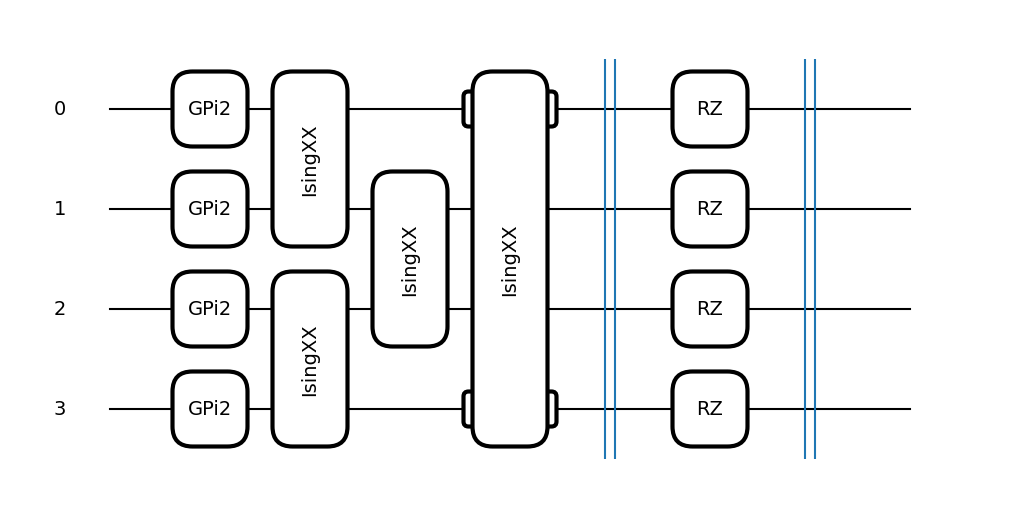

In [7]:
qml.draw_mpl(SGS_circ)(hZ, JX=1, JY=0, JZ=0,tau_steps=1)

Here we check that the SGS state is approximately an equal superposition of the ground and theexcited state

In [8]:
def fidelity(a,b):
    return abs(np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128')))**2               
def overlap(a,b):
    return np.vdot(np.array(a, dtype = 'complex128'),np.array(b, dtype = 'complex128'))

In [9]:
statevec = SGS_state(hZ, JX, JY, JZ,tau_steps=tau_steps, delta_tau=delta_tau)


print('{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec)))

0.457,0.489


To have better fitting we will employ Chebyshev timesteps in the time evolution process

In [10]:
def chebyshev_time(t_steps, delta_t):
    '''Using Chebyshev nodes as time to have better fit'''

    n_nodes = []
    
    for t in range(t_steps):
        n_nodes.append(t_steps*delta_t*(0.5*np.cos(np.pi*(t_steps-1-t)/(t_steps-1))+0.5))

    return n_nodes

In [11]:
#### CHEBYSHEV TIMESTEPS
def time_evolution(hX, JX=0, JY=0, JZ=0,t_steps=10, step=0, delta_t = 0.3):
    times = chebyshev_time(t_steps, delta_t)

    for i,t in enumerate(times[:step]):#range(t_steps):
        if i==0:
            dt=t
        else:
            dt = t - times[i-1]
        trotter_step(1,hX,JX,JY,JZ, dt)



device_state = qml.device("braket.local.qubit", wires=n_qubits,)
device = qml.device("braket.local.qubit", wires=n_qubits,shots=8192)#backend='braket_sv',
@qml.qnode(device)
def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliX(0)):
    '''Circuit returning the expectation value of time evoluted X_0 on the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)
    
    time_evolution(hX, JX, JY, JZ,t_steps,step, delta_t)

    return qml.sample(op = O, )#qml.expval(O)

@qml.qnode(device_state)
def evol_SGS_state(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3,):
    '''Circuit returning the SGS state obtained via Adiabatic Thermalization and then time evoluted
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau, )
    
    time_evolution(hX, JX, JY, JZ,t_steps, step, delta_t)

    return qml.state()



Again we check that the SGS state is approximately an equal superposition of the ground and the excited state during the time evolution

In [12]:
for t in range(t_steps):
    statevec = evol_SGS_state(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    print(t, '{:.3f},{:.3f}'.format(fidelity(grounds[0], statevec), fidelity(excs[0], statevec)))

0 0.457,0.489
1 0.457,0.489
2 0.457,0.489
3 0.456,0.487
4 0.455,0.486
5 0.454,0.489
6 0.456,0.497
7 0.479,0.490
8 0.497,0.467
9 0.441,0.471
10 0.412,0.489
11 0.430,0.460
12 0.466,0.461
13 0.481,0.486
14 0.402,0.455
15 0.425,0.468
16 0.455,0.489
17 0.489,0.465
18 0.464,0.473
19 0.426,0.496
20 0.444,0.492
21 0.468,0.484
22 0.477,0.485
23 0.480,0.490
24 0.481,0.492


And now we are ready to compute the expectation value at different time steps:

In [13]:
vals = []
errors = []
for t in range(t_steps):
    expval=0
    samples = evol_SGS_expval(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
    counts = {}
    counts[1] = np.sum(np.where(samples==1,1, 0 ))
    counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
    
    shots = counts[1]+counts[-1]
    p_0 = counts[1]/shots
    p_1 = counts[-1]/shots
    expval = (p_1*(-1)+ p_0)
    err = np.sqrt(4*p_0*p_1/(shots-1))# /
    errors.append(err)
    vals.append(expval)
    if t%5==0:
        print(t, f'{expval:.3f}, {err:.3f}')

0 -0.037, 0.011
5 -0.292, 0.011
10 -0.384, 0.010
15 0.459, 0.010
20 -0.502, 0.010


In the end we fit the points with a `cosine` function. The spectral gap will be given by
$$\Delta E = \frac{2\pi}{T}$$
where $T$ is the period of the oscillating function.

Numerical: 2.26191
Estimated: 2.17213+/-0.047178
Reltive error: 0.039690992198439294


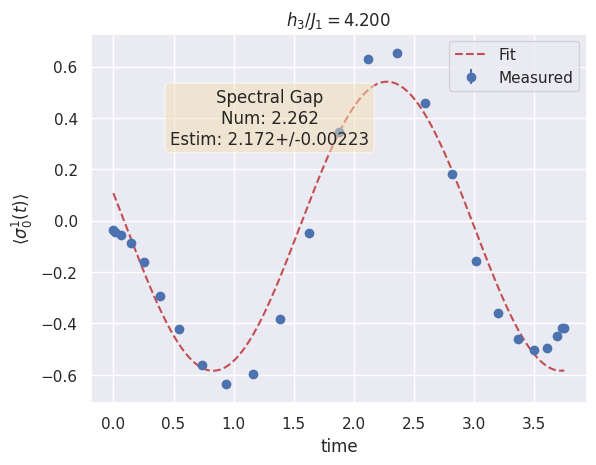

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.optimize import curve_fit
#FITTING PROCESS

def prefitting_function (x,a,b,c,d):
    f = a + b*np.cos(c*x + d)
    return f

x_axis =np.array(chebyshev_time(t_steps, delta_t))##np.linspace(0, t_steps*delta_t, t_steps)# 

omega = .5

p, pcov = curve_fit(prefitting_function, x_axis , vals, sigma= np.array(errors),
                    p0 = [ 0., .4, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)
plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')

plt.title(rf'$h_3/J_1={hZ:.3f}$')
plt.xlabel("time")
plt.ylabel(r"$\langle\sigma^1_0(t)\rangle$")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



print(f'Numerical: {spectral_gap:.5f}')
estim_gap = np.abs(p[2])
fit_err = np.sqrt(pcov[2][2])
print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
relativ_err = np.abs(spectral_gap-p[2])/spectral_gap
print(f'Reltive error: {relativ_err}')
plt.text(1.3,0.3, f'Spectral Gap\nNum: {spectral_gap:.3f}\nEstim: {estim_gap:.3f}+/-{pcov[2][2]:.3g}', 
         fontsize='medium', bbox=props, horizontalalignment='center')#, zorder=z)
# plt.grid()
plt.legend()
plt.show()

## Resilience to shot noise

In this section we test the robustness of our apporach for reducing number of shots

In [15]:
def SGS_circ(hZ, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3 ):
    '''Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last does not affect
    #state preparation
    #########
    # |+++++..> is a good starting point for thermalization 
    for i in range(n_qubits):
        qml.Hadamard(wires=i) # instead of GPi2(np.pi/2) to work with lightning.qubit
    for s in thermalization_steps:
        trotter_step(s,hZ,JX,JY,JZ,delta_tau)

## definition without decorator
def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliX(0)):
    '''Circuit returning the expectation value of time evoluted X_0 on the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau)
    
    time_evolution(hX, JX, JY, JZ,t_steps,step, delta_t)

    return qml.sample(op = O, )

In [41]:
hZ_s = np.linspace(2.2,14,15)

estimates = []
errs = []
nums = []

for k,hZ in enumerate(hZ_s):
    print(f'---{hZ:.3f}---')

    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    
    # thermalization step adjusting
    if hZ >= 5.:
        delta_tau = 0.25
    elif 3.6 < hZ < 5.:
        delta_tau = 0.2
    else: 
        delta_tau = 0.15

    ## time ev step adjusting
    ## fitting parameter adjusting
    if hZ < 3.:
        delta_t = 0.35
        omega = 0.5
    elif 3.<=hZ<4.5:
        delta_t = .15
        omega = 2
    elif 4.5<=hZ<5:
        delta_t = 0.15
        omega = 3
    elif 5<=hZ<6.:
        delta_t = 0.15
        omega = 3
    elif 6.<=hZ<7.:
        delta_t = 0.09
        omega = 5
    elif 7.<=hZ<8.8:
        delta_t = 0.06
        omega = 6
    elif 8.8<=hZ<11.:
        delta_t = 0.05
        omega = 7
    elif 11.<=hZ<13.:
        delta_t = 0.05
        omega = 10
    else:
        delta_t = 0.05
        omega = 11

    


    results = []
    esitmated_gaps = []
    fit_errors = []
    for s in np.linspace(100,10000, 20):
        device = qml.device("lightning.qubit", wires=n_qubits, shots=int(s))
        fun = qml.QNode(evol_SGS_expval, device)

        vals = []
        errors = []
        for t in range(t_steps):
            expval=0
            samples = fun(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,step=t,delta_t=delta_t,delta_tau=delta_tau)
            counts = {}
            counts[1] = np.sum(np.where(samples==1,1, 0 ))
            counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
            
            shots = counts[1]+counts[-1]
            p_0 = counts[1]/shots
            p_1 = counts[-1]/shots
            expval = (p_1*(-1)+ p_0)
            err = np.sqrt(4*p_0*p_1/(shots-1))# /
            errors.append(err)
            vals.append(expval)
        results.append([vals,errors])
        
        
        ## fitting
        x_axis = np.array(chebyshev_time(t_steps, delta_t))
        p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
        # plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
        p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
    
        estim_gap = np.abs(p[2])
        esitmated_gaps.append(estim_gap)
        # print(f'Numerical: {spectral_gap:.5f}')
        fit_err = np.sqrt(pcov[2][2])
        
        fit_errors.append(fit_err)
        # print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
        relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
        print(f'Reltive error: {relativ_err}', end='\r')#
    estimates.append(esitmated_gaps)
    errs.append(fit_errors)
    nums.append([spectral_gap for i in range(len(esitmated_gaps))])
    
    print()


---2.200---
Reltive error: 0.17742509058703136
---3.043---
Reltive error: 0.18169174185795376
---3.886---
Reltive error: 0.043683939428450315
---4.729---
Reltive error: 0.016521634860737815
---5.571---
Reltive error: 0.018877688297907876
---6.414---
Reltive error: 0.0041641852739947375
---7.257---
Reltive error: 0.028156794687246682
---8.100---
Reltive error: 0.07226568225739802
---8.943---
Reltive error: 0.00107311137506667687
---9.786---
Reltive error: 0.062611592983836124
---10.629---
Reltive error: 0.06668839248789134
---11.471---
Reltive error: 0.037401896610163694
---12.314---
Reltive error: 0.16229684866295476
---13.157---
Reltive error: 0.07084168261969256
---14.000---
Reltive error: 0.19999103696723425


/tmp/ipykernel_257084/466234693.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(list(hZ_s))+2)
/tmp/ipykernel_257084/466234693.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(np.linspace(100,10000, 20),estimates[k], yerr=errs[k],


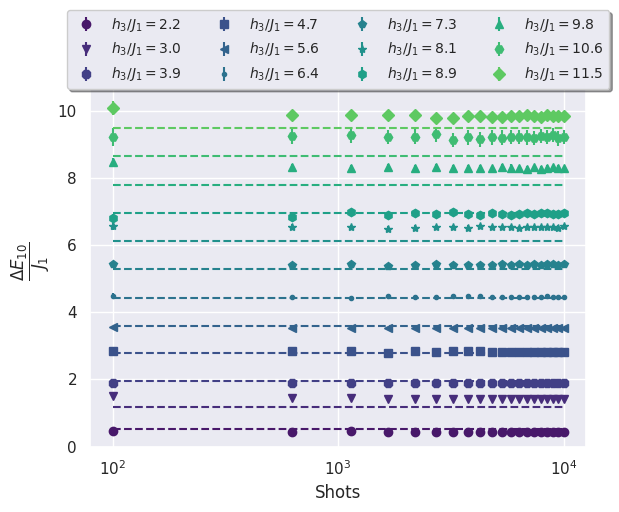

In [42]:
from matplotlib import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('viridis', len(list(hZ_s))+2)
markers = [ 'o', 'v',  '8', 's', '<','.', 'p', '*', 'h', '^','H', 'D', 'd', 'P', 'X','>',]+list(range(12))
for k, hX in enumerate(hZ_s[:-3]):    

    plt.errorbar(np.linspace(100,10000, 20),estimates[k], yerr=errs[k],
                 fmt='o', label=rf'$h_3/J_1=${hX:.1f}', c=cmap(k+1), marker=markers[k])
    plt.plot(np.linspace(100,10000, 20), nums[k], linestyle='dashed', c=cmap(k+1))#label=rf'Numerical $h_X/J_Z=${hX:.1f}'
lgd = ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.2),
          ncol=4, fancybox=True, shadow=True,fontsize=10)
# plt.legend(ncols=3, fontsize='small')
ax.set_ylim(0,11.)
plt.xlabel('Shots')
plt.ylabel(r'$\dfrac{\Delta E_{10}}{J_1}$')
plt.xscale('log')
fig.savefig(f'./images/Ising_1D_shot_noise_resilience_{n_qubits}.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Probing noise resilience

In this section we probe the noise resilience of our approach. At first we show that 40 Trotter steps works well in relationship with typical thermal relaxation times ($T_1$ and $T_2$) of ion-trapped platforms (in particular the data here are referred [IonQ Aria specifics](https://ionq.com/resources/ionq-aria-practical-performance)). Since the effects of thermal relaxation are besically negligible we also add readout error. Then we apply different kind of noisy channels at different levels of intensity in order to see where the method stops working.

### Thermalization is not an issue

In order to simulate noise we will employ the `default.mixed` simulator on Pennylane. Unfortunately this does not support `GPi2` gate, but for our purposes we can replace it with an `Hadamard` gate since we just need to prepare $|+\rangle^{\otimes L}$.

Here below we redefine our circuit with noise.

In [15]:
JZ = 0
JX = 1
JY = 0
hZ = 4.2

We set the worst case scenario where: $T_1=100s$, $T_2=1s$, $T_g=600\mu s$ (two-qubit gate time) and the readout error is $0.4\%$.

In [16]:
t1 = 100 #seconds
t2 = 1 #seconds
tg = 600e-6 #seconds (this is two-qubit gate time)-> worst case scenario
pe = 0. # thermal relaxation on the |0> state

read_err = .004 ## Readout Error

In [17]:
def trotter_step(s,hZ, JX=0, JY=0, JZ=0, delta_t = 0.3,noise=True):
    '''Trotter step function
    Params:
    s (float): performs  time evolution with tunable parameter:  s*hZ
    '''

    #X_nX_n+1 coupling
    if JX != 0:
        
        for i in range(0,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i]) 
            if noise: 
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=i)
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=(i+1)%n_qubits)
        
        for i in range(1,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i])
            if noise: 
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=i)
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=(i+1)%n_qubits)
        
        qml.Barrier(wires=range(n_qubits), only_visual=True)


    #Z term transverse field
    if hZ !=0 :
        for i in range(0,n_qubits):
            qml.RZ(-s*delta_t*hZ,wires=i)
            if noise:
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=i)
        qml.Barrier(wires=range(n_qubits), only_visual=True)


def SGS_circ(hZ, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3 ,noise=True):
    '''Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last does not affect
    #state preparation
    #########
    # |+++++..> is a good starting point for thermalization 
    for i in range(n_qubits):
        qml.Hadamard(wires=i) # instead of GPi2(np.pi/2)
        if noise:
            qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg, wires=i)
    for s in thermalization_steps:
        trotter_step(s,hZ,JX,JY,JZ,delta_tau,noise=noise)


def time_evolution(hX, JX=0, JY=0, JZ=0,t_steps=10, step=0, delta_t = 0.3,noise=True):
    times = chebyshev_time(t_steps, delta_t)

    for i,t in enumerate(times[:step]):#range(t_steps):
        if i==0:
            dt=t
        else:
            dt = t - times[i-1]
        trotter_step(1,hX,JX,JY,JZ, dt, noise=noise)



def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliX(0),noise=True):
    '''Circuit returning the expectation value of time evoluted X_0 on the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau, noise=noise)
    
    time_evolution(hX, JX, JY, JZ,t_steps,step, delta_t,noise=noise)

    return qml.sample(op = O, )#qml.expval(O)

(<Figure size 1500x500 with 1 Axes>, <Axes: >)

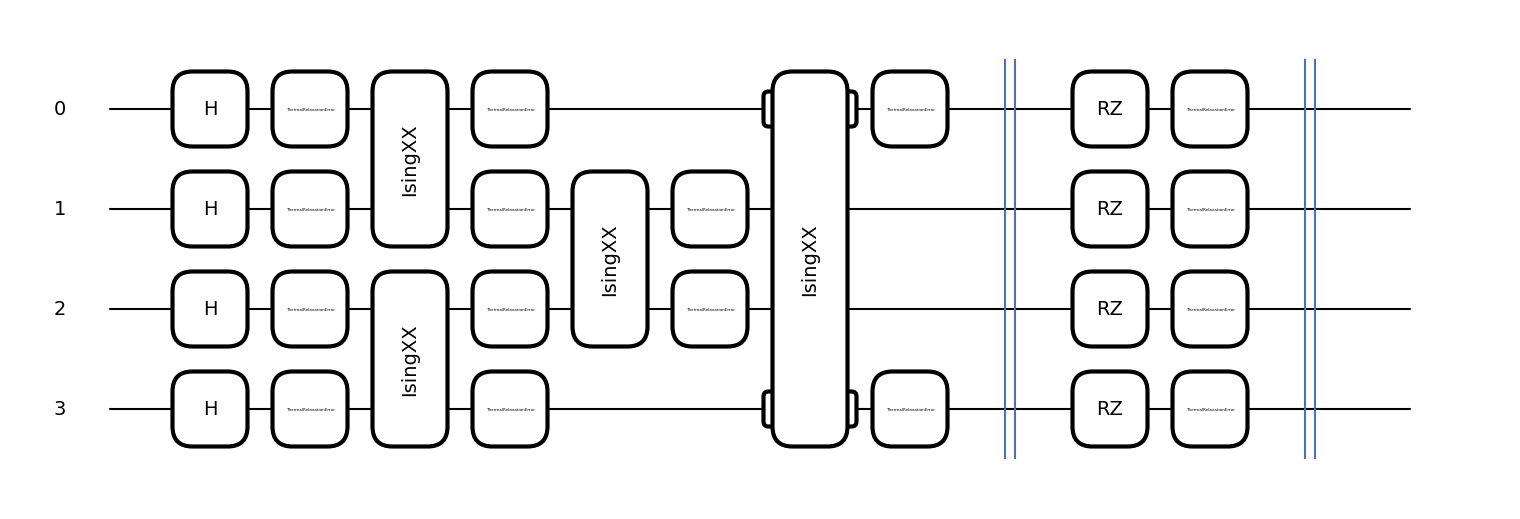

In [18]:
qml.draw_mpl(SGS_circ)(hZ, JX=1, JY=0, JZ=0,tau_steps=1)

In [19]:
## NOISY SIMULATIONs
device = qml.device("default.mixed", wires=n_qubits,shots=8192, readout_prob=read_err)
evol_SGS_expval = qml.QNode(evol_SGS_expval,device)
## DISCLAIMER: this automatic procedure may fail in performing the fitting
##              one should redo a separate fit in order to obtain a good estimate of the spectral gap

numerical_gaps = []
esitmated_gaps_noisy = []
fit_errors_noisy = []


hZ_s = np.linspace(2.2,14,15)

for hZ in hZ_s[:]:
    
    print(f'\n---hX={hZ:.3f}---')
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
       
    # thermalization step adjusting
    if hZ >= 5.:
        delta_tau = 0.25
    elif 3.6 < hZ < 5.:
        delta_tau = 0.2
    else: 
        delta_tau = 0.15

    ## time ev step adjusting
    ## fitting parameter adjusting
    if hZ < 3.:
        delta_t = 0.35
        omega = 0.5
    elif 3.<=hZ<4.5:
        delta_t = .15
        omega = 2
    elif 4.5<=hZ<5:
        delta_t = 0.15
        omega = 3
    elif 5<=hZ<6.:
        delta_t = 0.15
        omega = 3
    elif 6.<=hZ<7.:
        delta_t = 0.09
        omega = 5
    elif 7.<=hZ<8.8:
        delta_t = 0.06
        omega = 6
    elif 8.8<=hZ<11.:
        delta_t = 0.05
        omega = 7
    elif 11.<=hZ<13.:
        delta_t = 0.05
        omega = 10
    else:
        delta_t = 0.05
        omega = 11

    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    numerical_gaps.append(spectral_gap)

    # our estimate of the gap
    vals = []
    errors = []
    for t in range(t_steps):
        expval=0
        samples = evol_SGS_expval(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,
                                  step=t,delta_t=delta_t,delta_tau=delta_tau, noise=True)
        counts = {}
        counts[1] = np.sum(np.where(samples==1,1, 0 ))
        counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
        
        shots = counts[1]+counts[-1]
        p_0 = counts[1]/shots
        p_1 = counts[-1]/shots
        expval = (p_1*(-1)+ p_0)
        err = np.sqrt(4*p_0*p_1/(shots-1))# /
        errors.append(err)
        vals.append(expval)
    
    ## fitting 
    x_axis = np.array(chebyshev_time(t_steps, delta_t))
    
    p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
    # plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
    p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
    # plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)
    # plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')
        
    estim_gap = np.abs(p[2])
    esitmated_gaps_noisy.append(estim_gap)
    # print(f'Numerical: {spectral_gap:.5f}')
    fit_err = np.sqrt(pcov[2][2])
    fit_errors_noisy.append(fit_err)
    # print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
    relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
    print(f'Reltive error: {relativ_err}')
    
    


---hX=2.200---
Reltive error: 0.17516133371636672

---hX=3.043---
Reltive error: 0.1917642834169025

---hX=3.886---
Reltive error: 0.04360626480577531

---hX=4.729---
Reltive error: 0.019894490066696583

---hX=5.571---
Reltive error: 0.018236455380936344

---hX=6.414---
Reltive error: 0.0017053818355192139

---hX=7.257---
Reltive error: 0.03137219434529578

---hX=8.100---
Reltive error: 0.06814916768055644

---hX=8.943---
Reltive error: 0.0016989212953314242

---hX=9.786---
Reltive error: 0.06300047475187491

---hX=10.629---
Reltive error: 0.06483311605815156

---hX=11.471---
Reltive error: 0.04002278615907136

---hX=12.314---
Reltive error: 0.15488065700029438

---hX=13.157---
Reltive error: 0.06795365636399515

---hX=14.000---
Reltive error: 0.209562051538093


In [20]:
## NOISELESS

## DISCLAIMER: this automatic procedure may fail in performing the fitting
##              one should redo a separate fit in order to obtain a good estimate of the spectral gap

device = qml.device("lightning.qubit", wires=n_qubits,shots=8192)
evol_SGS_expval = qml.QNode(evol_SGS_expval,device)

numerical_gaps = []
esitmated_gaps = []
fit_errors = []


hZ_s = np.linspace(2.2,14,15)

for hZ in hZ_s[:]:
    
    print(f'\n---hX={hZ:.3f}---')
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap

    # thermalization step adjusting
    if hZ >= 5.:
        delta_tau = 0.25
    elif 3.6 < hZ < 5.:
        delta_tau = 0.2
    else: 
        delta_tau = 0.15

    ## time ev step adjusting
    ## fitting parameter adjusting
    if hZ < 3.:
        delta_t = 0.35
        omega = 0.5
    elif 3.<=hZ<4.5:
        delta_t = .15
        omega = 2
    elif 4.5<=hZ<5:
        delta_t = 0.15
        omega = 3
    elif 5<=hZ<6.:
        delta_t = 0.15
        omega = 3
    elif 6.<=hZ<7.:
        delta_t = 0.09
        omega = 5
    elif 7.<=hZ<8.8:
        delta_t = 0.06
        omega = 6
    elif 8.8<=hZ<11.:
        delta_t = 0.05
        omega = 7
    elif 11.<=hZ<13.:
        delta_t = 0.05
        omega = 10
    else:
        delta_t = 0.05
        omega = 11

    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    numerical_gaps.append(spectral_gap)

    # our estimate of the gap
    vals = []
    errors = []
    for t in range(t_steps):
        expval=0
        samples = evol_SGS_expval(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,
                                  step=t,delta_t=delta_t,delta_tau=delta_tau, noise=False)
        counts = {}
        counts[1] = np.sum(np.where(samples==1,1, 0 ))
        counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
        
        shots = counts[1]+counts[-1]
        p_0 = counts[1]/shots
        p_1 = counts[-1]/shots
        expval = (p_1*(-1)+ p_0)
        err = np.sqrt(4*p_0*p_1/(shots-1))# /
        errors.append(err)
        vals.append(expval)
    
    ## fitting 
    x_axis = np.array(chebyshev_time(t_steps, delta_t))
    
    p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
    # plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
    p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
   
        
    estim_gap = np.abs(p[2])
    esitmated_gaps.append(estim_gap)
    # print(f'Numerical: {spectral_gap:.5f}')
    fit_err = np.sqrt(pcov[2][2])
    fit_errors.append(fit_err)
    # print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
    relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
    print(f'Reltive error: {relativ_err}')
    
    


---hX=2.200---
Reltive error: 0.17048479127195731

---hX=3.043---
Reltive error: 0.1842470807235565

---hX=3.886---
Reltive error: 0.03960773399958226

---hX=4.729---
Reltive error: 0.022477218021270947

---hX=5.571---
Reltive error: 0.018891338401152338

---hX=6.414---
Reltive error: 0.004175599927622481

---hX=7.257---
Reltive error: 0.026259687818678976

---hX=8.100---
Reltive error: 0.06814586271180886

---hX=8.943---
Reltive error: 0.004532324947191935

---hX=9.786---
Reltive error: 0.06380304832139885

---hX=10.629---
Reltive error: 0.07339573672452127

---hX=11.471---
Reltive error: 0.03640026652994317

---hX=12.314---
Reltive error: 0.16049328891987025

---hX=13.157---
Reltive error: 0.06335140300127594

---hX=14.000---
Reltive error: 0.19863939251874893


In [21]:
full_range_gap = []
for hZ in  np.linspace(0.1,15,100):
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    full_range_gap.append(spectral_gap)

/tmp/ipykernel_243471/1466011378.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hZ_s, esitmated_gaps,yerr=fit_errors, label='Noiseless', fmt='o', marker='X')
/tmp/ipykernel_243471/1466011378.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hZ_s, esitmated_gaps_noisy,yerr=fit_errors_noisy, label='Th-relax + Readout', fmt='o', marker='x')


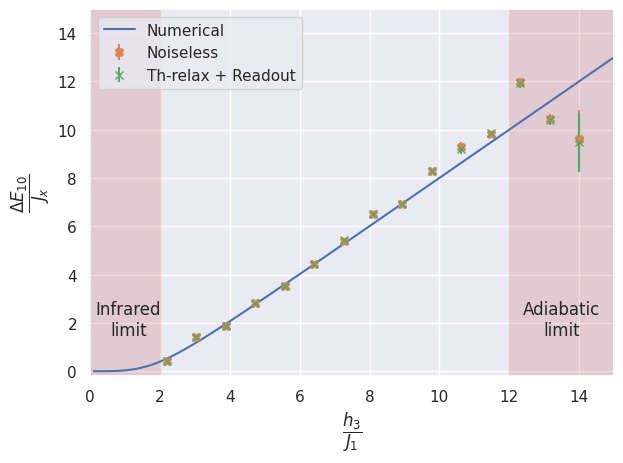

In [22]:
# plt.plot(hX_s, numerical_gaps, label='Numerical')
fig, ax = plt.subplots()
plt.plot(np.linspace(0.1,15,100), full_range_gap, label='Numerical')
plt.errorbar(hZ_s, esitmated_gaps,yerr=fit_errors, label='Noiseless', fmt='o', marker='X')
plt.errorbar(hZ_s, esitmated_gaps_noisy,yerr=fit_errors_noisy, label='Th-relax + Readout', fmt='o', marker='x')


plt.xlabel(r'$\dfrac{h_3}{J_1}$')
plt.ylabel(r'$\dfrac{\Delta E_{10}}{J_x}$')
# plt.xscale('log')
# plt.yscale('log')
ax.fill_betweenx([-1.,15], [0], [2], alpha=0.2, color='r')
ax.fill_betweenx([-1.,15], [12], [15], alpha=0.2, color='r')
plt.text(1.1,1.5, f'Infrared\nlimit', fontsize='medium',  horizontalalignment='center')
plt.text(13.5,1.5, f'Adiabatic\nlimit', fontsize='medium',  horizontalalignment='center')
ax.set_ylim([-0.2, 15])
ax.set_xlim([0, 15])
plt.legend()
plt.tight_layout()
plt.savefig(f'./images/thermal_relax_Ising_1D_spectralgap_running_{n_qubits}.pdf')
plt.show()

### Noise model

In [23]:
JZ = 0
JX = 1
JY = 0
hZ = 4.2

We take into account gate fidelities for constructing the noise model according to what reported in Appendix of [this paper](https://arxiv.org/pdf/1909.02611.pdf). Thanks to this formalism, we are able to design a depolarizing channel taking into account gate fidelities, $T1$, $T2$ and gate time.

In [24]:
t1 = 100 #seconds
t2 = 1 #seconds
tg1 = 135e-6 #seconds (single qubit gate time)
tg2 = 600e-6 #seconds (two-qubit gate time)
pe = 0. # thermal relaxation on the |0> state

read_err = .0039 ## Readout Error#1-99.550/100#


f_single = 1 - 0.0005#99.970/100	#
f_two = 1 - 0.004#98.600/100#

e_single = 1 - f_single
e_two = 1 - f_two
def depol_p(tg, e):
    d = np.exp(-tg/t1)+2*np.exp(-tg/t2)
    p = 1 + 3/d*(2*e-1)

    return p

p1 = depol_p(tg1, e_single)
p2 = depol_p(tg2, e_two)

p1, p2

(0.0009096383462927626, 0.007601174742245864)

In [25]:
def trotter_step(s,hZ, JX=0, JY=0, JZ=0, delta_t = 0.3,noise=True):
    '''Trotter step function
    Params:
    s (float): performs  time evolution with tunable parameter:  s*hZ
    '''

    #X_nX_n+1 coupling
    if JX != 0:
        
        for i in range(0,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i]) 
            if noise: 
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg2, wires=i)
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg2, wires=(i+1)%n_qubits)
                qml.DepolarizingChannel(p2, wires=i)
                qml.DepolarizingChannel(p2, wires=(i+1)%n_qubits)
        
        for i in range(1,n_qubits,2):
            qml.IsingXX(-2*JX*delta_t,wires=[(i+1)%n_qubits, i])
            if noise: 
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg2, wires=i)
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg2, wires=(i+1)%n_qubits)
                qml.DepolarizingChannel(p2, wires=i)
                qml.DepolarizingChannel(p2, wires=(i+1)%n_qubits)
        
        qml.Barrier(wires=range(n_qubits), only_visual=True)


    #Z term transverse field
    if hZ !=0 :
        for i in range(0,n_qubits):
            qml.RZ(-s*delta_t*hZ,wires=i)
            if noise:
                qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg1, wires=i)
                qml.DepolarizingChannel(p1, wires=i)
                
        qml.Barrier(wires=range(n_qubits), only_visual=True)


def SGS_circ(hZ, JX=0, JY=0, JZ=0,tau_steps=10, delta_tau = 0.3 ,noise=True):
    '''Circuit responsible for the preparation of the SGS state via Adiabatic Thermalization
    '''
    thermalization_steps = np.linspace(0, 1, tau_steps+2)[1:-1]#first and last does not affect
    #state preparation
    #########
    # |+++++..> is a good starting point for thermalization 
    for i in range(n_qubits):
        qml.Hadamard(wires=i) # instead of GPi2(np.pi/2)
        if noise:
            qml.ThermalRelaxationError(pe, t1=t1, t2=t2, tq=tg1, wires=i)
            qml.DepolarizingChannel(p1, wires=i)
    for s in thermalization_steps:
        trotter_step(s,hZ,JX,JY,JZ,delta_tau,noise=noise)


def time_evolution(hX, JX=0, JY=0, JZ=0,t_steps=10, step=0, delta_t = 0.3,noise=True):
    times = chebyshev_time(t_steps, delta_t)

    for i,t in enumerate(times[:step]):#range(t_steps):
        if i==0:
            dt=t
        else:
            dt = t - times[i-1]
        trotter_step(1,hX,JX,JY,JZ, dt, noise=noise)



def evol_SGS_expval(hX, JX=0, JY=0, JZ=0,tau_steps=10,t_steps=10, step=0, delta_tau = 0.3,delta_t = 0.3, O=qml.PauliX(0),noise=True):
    '''Circuit returning the expectation value of time evoluted X_0 on the SGS state obtained via Adiabatic Thermalization
    '''
    SGS_circ(hX, JX, JY, JZ,tau_steps, delta_tau, noise=noise)
    
    time_evolution(hX, JX, JY, JZ,t_steps,step, delta_t,noise=noise)

    return qml.sample(op = O, )#qml.expval(O)

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

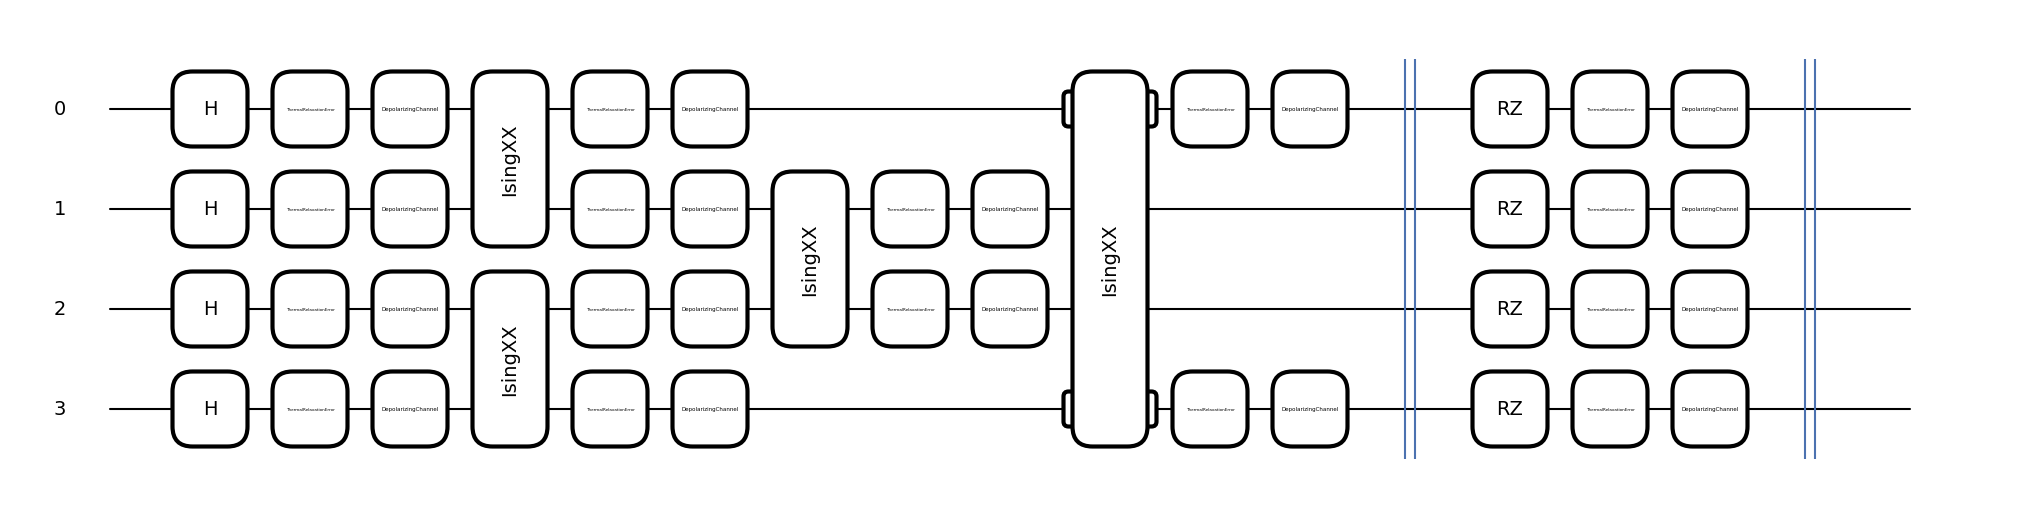

In [26]:
qml.draw_mpl(SGS_circ)(hZ, JX=1, JY=0, JZ=0,tau_steps=1)

Let's perform the scanning of the Ising model with an iterative procedure:

In [27]:
## NOISY SIMULATIONs
device = qml.device("default.mixed", wires=n_qubits,shots=8192, readout_prob=read_err)
evol_SGS_expval = qml.QNode(evol_SGS_expval,device)

## DISCLAIMER: this automatic procedure may fail in performing the fitting
##              one should redo a separate fit in order to obtain a good estimate of the spectral gap


numerical_gaps = []
esitmated_gaps_noisy = []
fit_errors_noisy = []

all_vals_noisy = {}
all_errors_noisy = {}
t_s_noisy = {}
hZ_s = np.linspace(2.2,14,15)

for hZ in hZ_s[:]:
    
    print(f'\n---hZ={hZ:.3f}---')
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    
    # thermalization step adjusting
    if hZ >= 5.:
        delta_tau = 0.25
    elif 3.6 < hZ < 5.:
        delta_tau = 0.2
    else: 
        delta_tau = 0.15

    ## time ev step adjusting
    ## fitting parameter adjusting
    if hZ < 3.:
        delta_t = 0.35
        omega = 0.5
    elif 3.<=hZ<4.5:
        delta_t = .15
        omega = 2
    elif 4.5<=hZ<5:
        delta_t = 0.15
        omega = 3
    elif 5<=hZ<6.:
        delta_t = 0.15
        omega = 3
    elif 6.<=hZ<7.:
        delta_t = 0.09
        omega = 5
    elif 7.<=hZ<8.8:
        delta_t = 0.06
        omega = 6
    elif 8.8<=hZ<11.:
        delta_t = 0.05
        omega = 7
    elif 11.<=hZ<13.:
        delta_t = 0.05
        omega = 10
    else:
        delta_t = 0.05
        omega = 11
        
    t_s_noisy[hZ]=delta_t*t_steps
    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    numerical_gaps.append(spectral_gap)

    # our estimate of the gap
    vals = []
    errors = []
    
    for t in range(0,t_steps):
        expval=0
        samples = evol_SGS_expval(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,
                                  step=t,delta_t=delta_t,delta_tau=delta_tau, noise=True)
        counts = {}
        counts[1] = np.sum(np.where(samples==1,1, 0 ))
        counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
        
        shots = counts[1]+counts[-1]
        p_0 = counts[1]/shots
        p_1 = counts[-1]/shots
        expval = (p_1*(-1)+ p_0)
        err = np.sqrt(4*p_0*p_1/(shots-1))# /
        errors.append(err)
        vals.append(expval)
    all_vals_noisy[hZ] = vals
    all_errors_noisy[hZ] = errors
    # fitting 
    x_axis = np.array(chebyshev_time(t_steps, delta_t))
    
    p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
    
    p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
    # if hZ>2:
    #     plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)
    #     plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
    #     plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')
    
    estim_gap = np.abs(p[2])
    esitmated_gaps_noisy.append(estim_gap)
    # print(f'Numerical: {spectral_gap:.5f}')
    fit_err = np.sqrt(pcov[2][2])
    fit_errors_noisy.append(fit_err)
    # print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
    relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
    print(f'Reltive error: {relativ_err}')
    
    


---hZ=2.200---
Reltive error: 0.40126502015531246

---hZ=3.043---
Reltive error: 0.4864680108752913

---hZ=3.886---
Reltive error: 0.08594480565956437

---hZ=4.729---
Reltive error: 0.012209952377556076

---hZ=5.571---
Reltive error: 0.023001750168644548

---hZ=6.414---
Reltive error: 0.005387603303127502

---hZ=7.257---
Reltive error: 0.01864692099698733

---hZ=8.100---
Reltive error: 0.04002800999049787

---hZ=8.943---
Reltive error: 0.07213083057869983

---hZ=9.786---
Reltive error: 0.061089664388482436

---hZ=10.629---
Reltive error: 0.046288261839779216

---hZ=11.471---
Reltive error: 0.06943513774862792

---hZ=12.314---
Reltive error: 0.08473579020959726

---hZ=13.157---
Reltive error: 0.09413381530132886

---hZ=14.000---
Reltive error: 0.2664661845330267


We can also assess the single measured regimes and see how is the fitting

Numerical: 3.59900
Estimated: 3.51621+/-0.058231
Reltive error: 0.02300338361899783
3.516220823786023


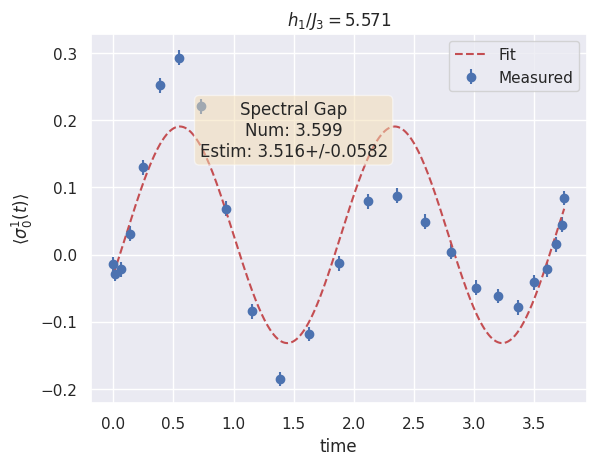

In [28]:
# selecting the regime
k = 4
hZ = hZ_s[k]

# recovering delta_t
delta_t = t_s_noisy[hZ]/t_steps

# loading expvals and shot errors
vals = all_vals_noisy[hZ]
errors = all_errors_noisy[hZ]

# loading true value of spectral gap
# spectral_gap = numerical_gaps[k]
grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
spectral_gap = (eigenvals[1]-eigenvals[0]).real
#FITTING PROCESS

def prefitting_function (x,a,b,c,d,):
    f = a + b*np.cos(c*x + d)
    return f

x_axis =np.array(chebyshev_time(t_steps, delta_t))##np.linspace(0, t_steps*delta_t, t_steps)# 

omega = 5.#
plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
p, pcov = curve_fit(prefitting_function, x_axis , vals, sigma= np.array(errors),
                    p0 = [ 0., .4, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)

plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')

plt.title(rf'$h_1/J_3={hZ:.3f}$')
plt.xlabel("time")
plt.ylabel(r"$\langle\sigma^1_0(t)\rangle$")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



print(f'Numerical: {spectral_gap:.5f}')
estim_gap = np.abs(p[2])
fit_err = np.sqrt(pcov[2][2])
print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
print(f'Reltive error: {relativ_err}')
plt.text(1.5,np.max(vals)/2, f'Spectral Gap\nNum: {spectral_gap:.3f}\nEstim: {estim_gap:.3f}+/-{fit_err:.3g}', 
         fontsize='medium', bbox=props, horizontalalignment='center')#, zorder=z)
print(esitmated_gaps_noisy[k])
# esitmated_gaps_noisy[k] = estim_gap
# fit_errors_noisy[k] = fit_err

plt.legend()
plt.show()

In [29]:
## NOISELESS for comparison

## DISCLAIMER: this automatic procedure may fail in performing the fitting
##              one should redo a separate fit in order to obtain a good estimate of the spectral gap

device = qml.device("lightning.qubit", wires=n_qubits,shots=8192)
evol_SGS_expval = qml.QNode(evol_SGS_expval,device)

numerical_gaps = []
esitmated_gaps = []
fit_errors = []

all_vals = {}
all_errors = {}
t_s = {}
hZ_s = np.linspace(2.2,14,15)

for hZ in hZ_s[:]:
    
    print(f'\n---hX={hZ:.3f}---')
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    # different regimes needs different time steps
    # the period is inverse proportial to the spectral gap
    
    # thermalization step adjusting
    if hZ >= 5.:
        delta_tau = 0.25
    elif 3.6 < hZ < 5.:
        delta_tau = 0.2
    else: 
        delta_tau = 0.15

    ## time ev step adjusting
    ## fitting parameter adjusting
    if hZ < 3.:
        delta_t = 0.35
        omega = 0.5
    elif 3.<=hZ<4.5:
        delta_t = .15
        omega = 2
    elif 4.5<=hZ<5:
        delta_t = 0.15
        omega = 3
    elif 5<=hZ<6.:
        delta_t = 0.15
        omega = 3
    elif 6.<=hZ<7.:
        delta_t = 0.09
        omega = 5
    elif 7.<=hZ<8.8:
        delta_t = 0.06
        omega = 6
    elif 8.8<=hZ<11.:
        delta_t = 0.05
        omega = 7
    elif 11.<=hZ<13.:
        delta_t = 0.05
        omega = 10
    else:
        delta_t = 0.05
        omega = 11

    
    t_s[hZ]=delta_t*t_steps

    #numerical gap
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    numerical_gaps.append(spectral_gap)

    # our estimate of the gap
    vals = []
    errors = []
    for t in range(t_steps):
        expval=0
        samples = evol_SGS_expval(hZ, JX, JY, JZ,tau_steps=tau_steps,t_steps=t_steps,
                                  step=t,delta_t=delta_t,delta_tau=delta_tau, noise=False)
        counts = {}
        counts[1] = np.sum(np.where(samples==1,1, 0 ))
        counts[-1] = np.sum(np.where(samples==-1,1, 0 ))
        
        shots = counts[1]+counts[-1]
        p_0 = counts[1]/shots
        p_1 = counts[-1]/shots
        expval = (p_1*(-1)+ p_0)
        err = np.sqrt(4*p_0*p_1/(shots-1))# /
        errors.append(err)
        vals.append(expval)
    
    all_vals[hZ] = vals
    all_errors[hZ] = errors
    
    ## fitting 
    x_axis = np.array(chebyshev_time(t_steps, delta_t))
    
    p0 = [ 0., 0.4, omega , 0] # initial fitting parameters
    # plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
    p, pcov = curve_fit(prefitting_function, x_axis , vals, p0 = p0,sigma=errors)
   
        
    estim_gap = np.abs(p[2])
    esitmated_gaps.append(estim_gap)
    # print(f'Numerical: {spectral_gap:.5f}')
    fit_err = np.sqrt(pcov[2][2])
    fit_errors.append(fit_err)
    # print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
    relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
    print(f'Reltive error: {relativ_err}')
    
    


---hX=2.200---
Reltive error: 0.17329412514893597

---hX=3.043---
Reltive error: 0.18784608390336358

---hX=3.886---
Reltive error: 0.03700133403142098

---hX=4.729---
Reltive error: 0.017467793173031897

---hX=5.571---
Reltive error: 0.020024948533191214

---hX=6.414---
Reltive error: 0.004285151341862536

---hX=7.257---
Reltive error: 0.026552552107728927

---hX=8.100---
Reltive error: 0.06466188311274998

---hX=8.943---
Reltive error: 0.0018996666855137568

---hX=9.786---
Reltive error: 0.06538699939134796

---hX=10.629---
Reltive error: 0.07551545216415896

---hX=11.471---
Reltive error: 0.03603542563609068

---hX=12.314---
Reltive error: 0.16006949648177562

---hX=13.157---
Reltive error: 0.06932537031219727

---hX=14.000---
Reltive error: 0.19395695473869223


Numerical: 3.59900
Estimated: 3.52693+/-0.035211
Reltive error: 0.020024960316453802
3.52693434543324


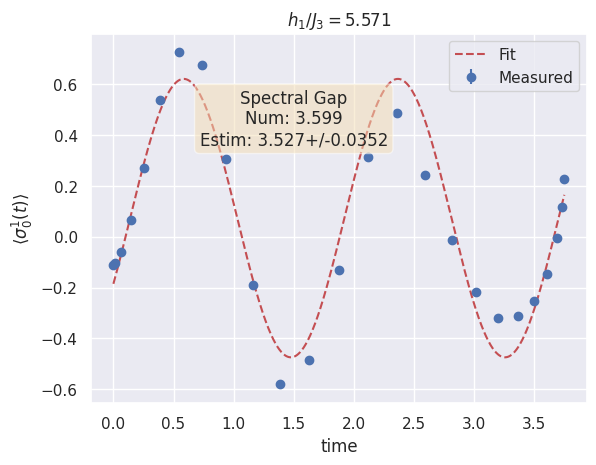

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.optimize import curve_fit

# selecting the regime
k = 4
hZ = hZ_s[k]

# recovering delta_t
delta_t = t_s[hZ]/t_steps

# loading expvals and shot errors
vals = all_vals[hZ]
errors = all_errors[hZ]

# loading true value of spectral gap
spectral_gap = numerical_gaps[k]

#FITTING PROCESS

def prefitting_function (x,a,b,c,d):
    f = a + b*np.cos(c*x + d)
    return f

x_axis =np.array(chebyshev_time(t_steps, delta_t))##np.linspace(0, t_steps*delta_t, t_steps)# 

omega = 5.#
plt.errorbar(x_axis,vals, yerr=errors, fmt='o', label='Measured')
p, pcov = curve_fit(prefitting_function, x_axis , vals, sigma= np.array(errors),
                    p0 = [ 0., .4, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)

plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p[0], p[1], p[2], p[3]),linestyle='dashed', label='Fit', color='r')

plt.title(rf'$h_1/J_3={hZ:.3f}$')
plt.xlabel("time")
plt.ylabel(r"$\langle\sigma^1_0(t)\rangle$")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



print(f'Numerical: {spectral_gap:.5f}')
estim_gap = np.abs(p[2])
fit_err = np.sqrt(pcov[2][2])
print(f'Estimated: {estim_gap:.5f}+/-{fit_err:.5g}')
relativ_err = np.abs(spectral_gap-estim_gap)/spectral_gap
print(f'Reltive error: {relativ_err}')
plt.text(1.5,np.max(vals)/2, f'Spectral Gap\nNum: {spectral_gap:.3f}\nEstim: {estim_gap:.3f}+/-{fit_err:.3g}', 
         fontsize='medium', bbox=props, horizontalalignment='center')#, zorder=z)
print(esitmated_gaps[k])
# esitmated_gaps[k] = estim_gap
# fit_errors[k] = fit_err

plt.legend()
plt.show()

In [31]:
full_range_gap = []
for hZ in  np.linspace(0.1,15,100):
    grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
    spectral_gap = (eigenvals[1]-eigenvals[0]).real
    full_range_gap.append(spectral_gap)

In [32]:
##NOISY
np.save('./data/noisy_spectralgap_Ising_1D.npy', esitmated_gaps_noisy)
np.save('./data/noisy_fit_errors_Ising_1D.npy', fit_errors_noisy)
np.save('./data/noisy_expvals_Ising_1D.npy', all_vals_noisy)
np.save('./data/noisy_expval_errors_Ising_1D.npy', all_errors_noisy)

## NOISELESS
np.save('./data/spectralgap_Ising_1D.npy', esitmated_gaps)
np.save('./data/fit_errors_Ising_1D.npy', fit_errors)
np.save('./data/expvals_Ising_1D.npy', all_vals)
np.save('./data/expval_errors_Ising_1D.npy', all_errors)

In [36]:
aria_gaps = np.load('./data/aria_spectralgap_Ising_1D.npy')
aria_errors= np.load('./data/aria_fit_errors_Ising_1D.npy')

noisy_gaps = np.load('./data/noisy_spectralgap_Ising_1D.npy')
noisy_errors= np.load('./data/noisy_fit_errors_Ising_1D.npy')

noiseless_gaps = np.load('./data/spectralgap_Ising_1D.npy')
noiseless_errors= np.load('./data/fit_errors_Ising_1D.npy')

/tmp/ipykernel_243471/29714609.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hZ_s, noiseless_gaps,yerr=noiseless_errors, label='Noiseless',
/tmp/ipykernel_243471/29714609.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hZ_s, noisy_gaps,yerr=noisy_errors, label='Noisy',
/tmp/ipykernel_243471/29714609.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(hZ_s[5:8], aria_gaps,yerr=aria_errors, label='IonQ Aria',


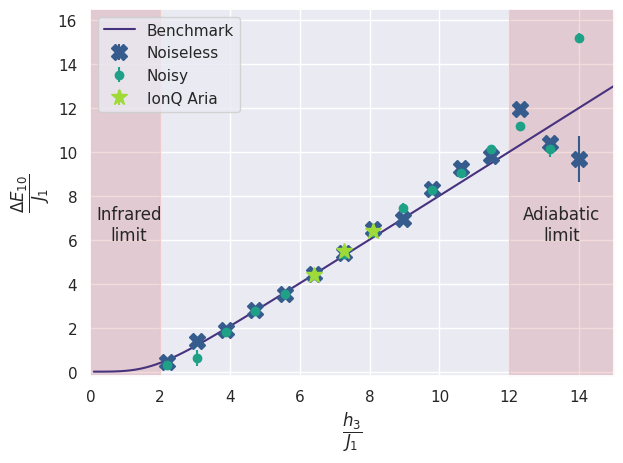

In [37]:
fig, ax = plt.subplots()
cmap = sns.color_palette("viridis")
plt.plot(np.linspace(0.1,15,100), full_range_gap, label='Benchmark', c=cmap[0])
plt.errorbar(hZ_s, noiseless_gaps,yerr=noiseless_errors, label='Noiseless', 
             fmt='o', marker='X', markersize=12, c=cmap[1])
plt.errorbar(hZ_s, noisy_gaps,yerr=noisy_errors, label='Noisy', 
             fmt='o', marker='.', markersize=12,c=cmap[3])
plt.errorbar(hZ_s[5:8], aria_gaps,yerr=aria_errors, label='IonQ Aria', 
             fmt='o', marker='*',  markersize=12, c=cmap[5])


plt.xlabel(r'$\dfrac{h_3}{J_1}$')
plt.ylabel(r'$\dfrac{\Delta E_{10}}{J_1}$')
# plt.xscale('log')
# plt.yscale('log')
ax.fill_betweenx([-1.,17], [0], [2], alpha=0.2, color='r')
ax.fill_betweenx([-1.,17], [12], [15], alpha=0.2, color='r')
plt.text(1.1,6, f'Infrared\nlimit', fontsize='medium',  horizontalalignment='center')
plt.text(13.5,6, f'Adiabatic\nlimit', fontsize='medium',  horizontalalignment='center')
ax.set_ylim([-0.2, 16.5])
ax.set_xlim([0, 15])
plt.legend()
plt.tight_layout()
plt.savefig(f'./images/noisy_Ising_1D_spectralgap_running_{n_qubits}.pdf')
plt.show()

5.26987203973132
5.409800554795008
5.368151075921475
5.487944678286385


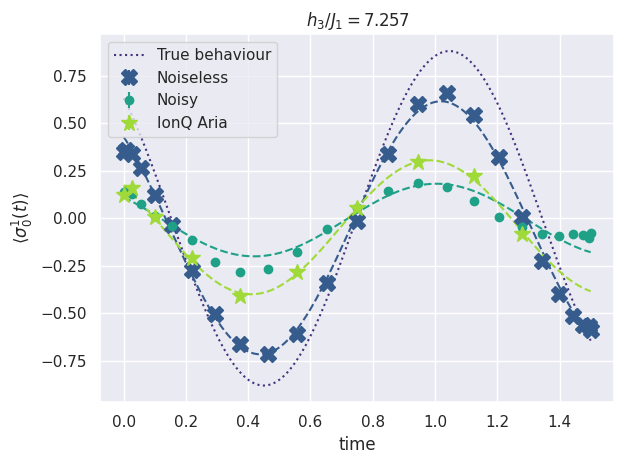

In [22]:
import numpy as np
import pennylane.numpy as np_qml
import seaborn as sns
n_qubits = 4

all_vals = np.load('./data/ionq_Aria_all_vals.npy', allow_pickle=True)[()]
all_errors = np.load('./data/ionq_Aria_all_errors.npy', allow_pickle=True)[()]

tau_steps = 15#thermalization steps
t_steps = 25 # time evolution steps

hZ_s = np_qml.linspace(2.2,14,15)

d = {f'{hZ_s[5]}':[hZ_s[5], .25,.09],
         f'{hZ_s[6]}':[hZ_s[6], .25,.06],
         f'{hZ_s[7]}':[hZ_s[7], .25,.06]}


k = 6


v = d[f'{hZ_s[k]}']

hZ = v[0]
delta_tau = v[1]
delta_t = v[2]

vals = all_vals[hZ]
errors = all_errors[hZ]

cmap = sns.color_palette("viridis")

x_axis =np.array(chebyshev_time(t_steps, delta_t))#[::2][:-3]##np.linspace(0, t_steps*delta_t, t_steps)# 


plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)


noiseless_expvals = np.load('./data/expvals_Ising_1D.npy', allow_pickle=True)[()][float(hZ)]#[::2][:-3]
noiseless_expv_err = np.load('./data/expval_errors_Ising_1D.npy', allow_pickle=True)[()][float(hZ)]#[::2][:-3]
noisy_expvals = np.load('./data/noisy_expvals_Ising_1D.npy', allow_pickle=True)[()][float(hZ)]#[::2][:-3]
noisy_expv_err = np.load('./data/noisy_expval_errors_Ising_1D.npy', allow_pickle=True)[()][float(hZ)]#[::2][:-3]

plt.errorbar(x_axis,noiseless_expvals, yerr=noiseless_expv_err, 
             fmt='X', label='Noiseless',  markersize=12,c=cmap[1])
plt.errorbar(x_axis,noisy_expvals, yerr=noisy_expv_err, 
             fmt='.', label='Noisy',  markersize=12, c=cmap[3])
plt.errorbar(x_axis[::2][:-3],vals, yerr=errors, 
             fmt='*', label='IonQ Aria', markersize=12, c=cmap[5])

omega = 5

p_noiseless, pcov_noiseless = curve_fit(prefitting_function, x_axis , noiseless_expvals, sigma= np.array(noiseless_expv_err),
                    p0 = [ 0., .4, omega, 0],)
p_noisy, pcov_noisy = curve_fit(prefitting_function, x_axis , noisy_expvals, sigma= np.array(noisy_expv_err),
                    p0 = [ 0., .4, omega, 0],)
p_aria, pcov_aria = curve_fit(prefitting_function, x_axis[::2][:-3] , vals, sigma= np.array(errors),
                    p0 = [ 0., .4, omega, 0],)
                    

plot_x_axis = np.linspace(0, t_steps*delta_t, 1000)

grounds,excs, eigenvals = tfim_spectral_states(n_qubits, hZ)
spectral_gap = (eigenvals[1]-eigenvals[0]).real

a= 0.8796528112548948 # amplitude obtained with `fin_observable.ipynb`
phi = p_noiseless[3] # setting same relative phase as noiseless simulations

plt.plot(plot_x_axis, prefitting_function(plot_x_axis, 0, a, spectral_gap, phi),
        color=cmap[0], label='True behaviour', linestyle='dotted')

plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p_noiseless[0], p_noiseless[1], p_noiseless[2], p_noiseless[3]),
         linestyle='dashed',  color=cmap[1])
plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p_noisy[0], p_noisy[1], p_noisy[2], p_noisy[3]),
         linestyle='dashed',  color=cmap[3])
plt.plot(plot_x_axis, prefitting_function(plot_x_axis, p_aria[0], p_aria[1], p_aria[2], p_aria[3]),
         linestyle='dashed', color=cmap[5])

print(spectral_gap)
print(p_noiseless[2])
print(p_noisy[2])
print(p_aria[2])


plt.title(rf'$h_3/J_1={hZ:.3f}$')
plt.xlabel("time")
plt.ylabel(r"$\langle\sigma^1_0(t)\rangle$")
plt.tight_layout()
plt.legend()
plt.savefig('./images/wavy_plot_noise.pdf')

plt.show()

In [34]:
## average relative error
np.mean((np.abs(np.array(numerical_gaps)-np.array(esitmated_gaps_noisy)))/np.array(numerical_gaps))

0.11781545054176827

In [35]:
## average absolute error
np.mean((np.abs(np.array(numerical_gaps)-np.array(esitmated_gaps_noisy))))

0.5733434433220039